# Importing packages

In [1]:
# Importing, cleaning and visualization
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Model Validation
from sklearn.model_selection import train_test_split,StratifiedKFold
# Imputation
from sklearn.impute import KNNImputer
# Model Evaluation
from sklearn.metrics import confusion_matrix,plot_roc_curve,accuracy_score,recall_score, precision_score,plot_confusion_matrix,f1_score
from sklearn.model_selection import cross_val_score
# Modelling
from sklearn.ensemble import RandomForestClassifier
# Balancing
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
# Scaling data
from sklearn.preprocessing import StandardScaler
# Model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Feature selection
from boruta import BorutaPy
# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [2]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.


#### Functions

In [3]:
# Function to remove missing values above a given threshold
def missing_remove(dataframe, threshold):
    """
    Function to remove columns with missing data that is above the set percentage threshold limit
    
    Required arguments - 
    dataframe - Dataframe for processing(type-Pandas Dataframe)
    threshold - threshold above which columns will be removed(type-float)
    
    Optional arguments - None
    
    Expected output - Message with threshold value and number of columns removed
    Pandas Dataframe that does not contain columns that have more missing values than the threshold value
    
    """
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold].tolist()
    print(f"# Features deleted with more than {threshold} % missing values", len(columns))
    return dataframe.drop(columns, axis=1,inplace=True)

In [4]:
def replace_outlier(val, mean, std):
    """
    Function to replace a value that is greater that mean+3*standard deviation with mean+3*standard deviation
    
    Required arguments - 
    val - any value - float
    mean - mean of values -float
    std - standard deviation of values - float
        
    Optional arguments - None
    
    Expected output - If value is lower than mean+3*standard deviation then returns value
                      If value is higher than mean+3*standard deviation then returns mean+3*standard deviation    
    """
    if val > mean + 3*std:
        return mean + 3*std 
    elif val < mean - 3*std:
        return mean - 3*std
    return val

In [5]:
def evaluate(model, X_train,X_test,y_train,y_test):
    """
    Function to fit any model on the train data and evaluate the model on the test data on the basis of confusion matric, 
    AUC, F1 Score, Sensitivity, Recall and Precision
    
    Required arguments - 
    model - Name of the model including model parameters
    X_train - training data
    X_test - test data
    y_train - training data target variable
    y_test - validatation data
    
    Optional arguments - None
    
    Expected output - Output message - model name and parameters,Testing Accuracy, F1 score, Sensitivity, Recall, Precision
                      Plot of the Confusion matrix and AUC
    
    """
    figure(figsize=(8, 5), dpi=80)
    model.fit(X_train, y_train)
    # Scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    y_pred = model.predict(X_test)
    cm=confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d",cmap="YlOrRd",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])
    ax = plt.gca()
    plot = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
    print("Model Name:", model)
    f1score = f1_score(y_test, y_pred, average='micro')
    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    print("F1 Score:", f1score) 
    print("Sensitivity:" , sensitivity)
    print("Recall:" , recall)
    print("Precision:" , precision)

In [6]:
def BorutaFeatureSelection (X_train, y_train) :
    """
    A Function to use find the best features using Boruta along with the feature scores. Only features with Rank 1 will 
    be selected and tentative features will not be considered
    
    Required arguments - 
    X_train - training data
    y_train - training data target variable
    
    Optional arguments - None
    
    Expected output - Output message - Feature rank and whethen the feature will be kept or removed
                                     - Final features
                      Pandas Dataframe that contains only final features selected using Boruta
    """
    feature_names = np.array(X_train.columns)

    model =RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=6,class_weight='balanced_subsample')
    model.fit(X_train, y_train)
    
    feature_selector = BorutaPy(model, random_state=2, verbose=2,max_iter=455,n_estimators=200)

    feature_selector.fit(X_train.to_numpy(),y_train)

    feature_selector.support_

    feature_selector.ranking_

    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
    return pd.DataFrame(X_train.filter(final_features)) , final_features

In [7]:
def Sampling(X_train, y_train, sampler):
    """
    Function to use any balacing technique on a dataframe
    
    Required arguments - 
    X_train - training data(pandas dataframe)
    y_train - training data target variable(pandas dataframe)
    sampler - Name of balacing technique(string)
    
    Optional arguments - None
    
    Expected output - Pandas Dataframe with balanced data
    
    # Himansha to add counter description
    """
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
        
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)
        
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Importing and basic cleaning

In [8]:
# Importing data from internet in runtime
data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"

In [9]:
# Assigning data to a pandas dataframe
secom_data = pd.read_csv(data_url,sep=' ',header=None)

In [10]:
# Renaming the columns 
secom_data.columns = ["Feature_"+str(column+1) for column in range(len(secom_data.columns))]
secom_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_581,Feature_582,Feature_583,Feature_584,Feature_585,Feature_586,Feature_587,Feature_588,Feature_589,Feature_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [11]:
# Importing target data from internet in runtime
label_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [12]:
# Assigning target data to a pandas dataframe
secom_labels = pd.read_csv(label_url, sep = " ",header=None)

In [13]:
# Renaming the columns 
secom_labels.columns = ["Classification","Timestamp"]

In [14]:
# Changing datatype for consitency
secom_labels['Timestamp'] = pd.to_datetime(secom_labels['Timestamp'],errors='raise')

In [15]:
# Merging the data
data= pd.concat([secom_labels,secom_data],axis=1)

In [16]:
# Dropping the timestamp column as it provides no insights
data.drop(columns="Timestamp", errors='raise',inplace=True)

In [17]:
# Using the classification column as the target variable
target = data[['Classification']]
data.drop(['Classification'], axis=1,inplace=True)

# Spliting the data into training set and test set

#### We split the data into a ratio of 80:20. Since the dataset is not large enough, we use 80% of the data for training. We will train the model on the training data and evaluate the model on the test data

#### We use the startify parameter as the data is imbalanced on the basis of pass and fail and this will ensure the same is retained when we split the data. The Random state argument will help us create a reproducible data. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.20, random_state=42, stratify=target)

In [19]:
# # Relabeling target variables 1 is pass and 0 is fail
# y_train = y_train.replace(to_replace=[-1, 1], value=["Pass", "Fail"])
# y_test = y_test.replace(to_replace=[-1, 1], value=["Pass", "Fail"])

# Removing columns with more that 50% missing values

In [20]:
X_train_missing = X_train
missing_remove(X_train_missing, 0.5)
X_train_missing.shape

# Features deleted with more than 0.5 % missing values 32


(1253, 558)

In [21]:
# From test set deleting columns that are removed in training set
X_test_missing = X_test[np.array(X_train_missing.columns)]
X_test_missing.shape

(314, 558)

# Replacing outliers with 3s boundary

In [22]:
# replace with 3s in X_train
for col in X_train_missing.columns:
    mean = X_train_missing[col].mean()
    std_dev = X_train_missing[col].std(axis=0)
    X_train_missing[col] = X_train_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

In [23]:
# replace with 3s in X_test
for col in X_test_missing.columns:
    mean = X_test_missing[col].mean()
    std_dev = X_test_missing[col].std(axis=0)
    X_test_missing[col] = X_test_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

# Imputing the missing values with KNN

In [24]:
knn = KNNImputer()
knn.fit(X_train_missing)
X_train_knn=pd.DataFrame(knn.transform(X_train_missing), columns=X_train_missing.columns)
X_train_knn.isna().sum().sum()

0

In [25]:
knn.fit(X_test_missing)
X_test_knn=pd.DataFrame(knn.transform(X_test_missing), columns=X_test_missing.columns)
X_test_knn.isna().sum().sum()

0

In [26]:
y_test.head()

,Classification
246,-1
1315,-1
444,-1
296,-1
1295,-1


# Feature Selection using Boruta

In [27]:
X_train_boruta , final_features = BorutaFeatureSelection(X_train_knn,y_train.values.ravel())

Iteration: 	1 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	2 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	3 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	4 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	5 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	6 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	7 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	8 / 455
Confirmed: 	0
Tentative: 	27
Rejected: 	531
Iteration: 	9 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	10 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	11 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	12 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	13 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	14 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	15 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	16 / 455
Confirmed: 	6
Tentat

Iteration: 	127 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	128 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	129 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	130 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	131 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	132 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	133 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	134 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	135 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	136 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	137 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	138 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	139 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	140 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	141 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

Iteration: 	252 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	253 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	254 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	255 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	256 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	257 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	258 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	259 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	260 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	261 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	262 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	263 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	264 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	265 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	266 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

Iteration: 	377 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	378 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	379 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	380 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	381 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	382 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	383 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	384 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	385 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	386 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	387 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	388 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	389 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	390 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	391 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

In [28]:
# From test set deleting columns that are removed in training set
X_test_boruta = X_test_knn[np.array(X_train_boruta.columns)]
X_test_boruta.shape

(314, 20)

### Checking the correlation between variables

Text(0.5, 1.0, 'Heatmap for the Data')

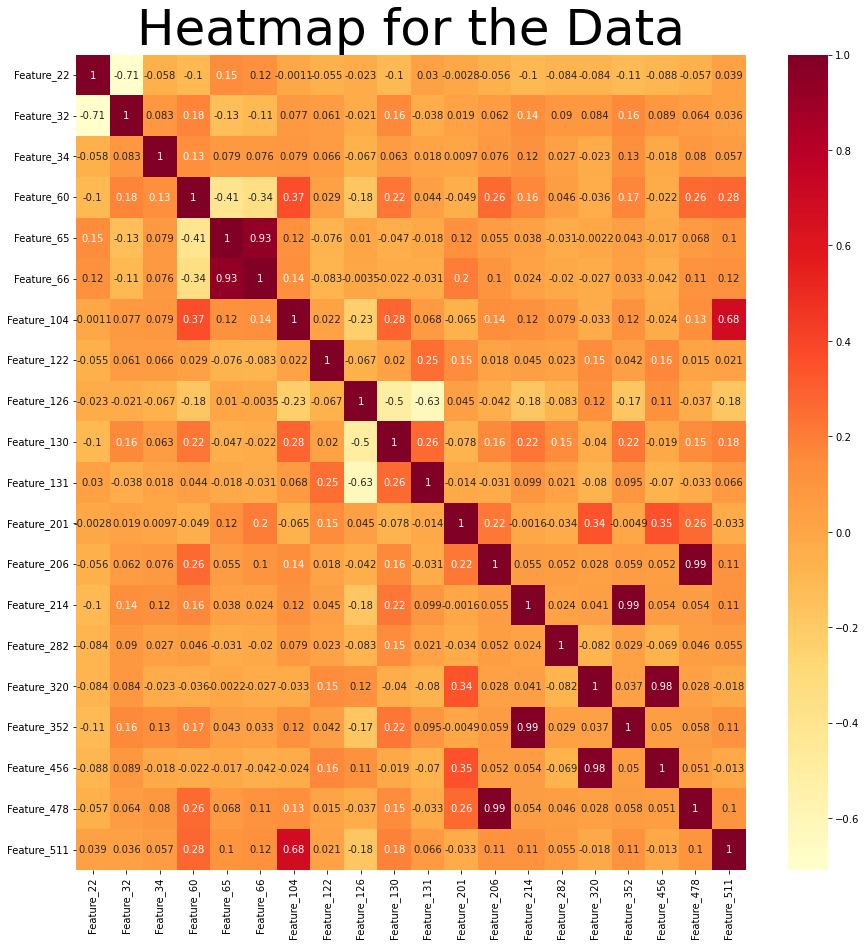

In [29]:
# Heatmap for correlation
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(X_train_boruta.corr(),cmap="YlOrRd",annot=True)
plt.title('Heatmap for the Data', fontsize = 50)

### Analysing the best featues

Text(0.5, 0, 'Feature Importance')

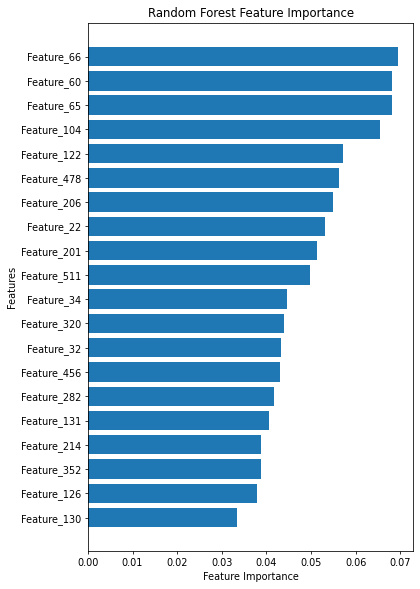

In [30]:
model = RandomForestClassifier()
model.fit(X_train_boruta, y_train.values.ravel())
feature_selector = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100)
figure(figsize=(6, 10), dpi=70)
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train_boruta.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance')
plt.ylabel('Features')
plt.xlabel("Feature Importance")

# Balancing the data using ROSE

In [31]:
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

[267491.02780486    907.99040754]

 Total Variance Explained: 99.93


'Distribution of Target Variable after balancing using SMOTE'

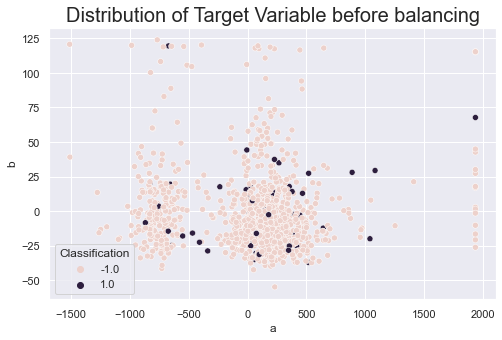

In [32]:
pca = PCA(n_components=2)
pca.fit(X_train_boruta)
g = pca.transform(X_train_boruta)
g = pd.DataFrame(g, columns=['a','b'])
g['Classification'] = y_train
sns.set(rc={'figure.figsize':(8,5)})
sns.scatterplot(data = g , x='a' , y='b', hue = g['Classification'],legend= True )
print(pca.explained_variance_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))
plt.title('Distribution of Target Variable before balancing', fontsize = 20)
"Distribution of Target Variable after balancing using SMOTE"

In [33]:
# Sampling technique

def Sampling(X_train, y_train, sampler):

    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [34]:
# Imbalance treatment
from collections import Counter
X_resampled, y_resampled = Sampling(X_train_boruta, y_train,'SMOTE')

Counter({'Classification': 1})


Text(0.5, 1.0, 'Distribution of Target Variable after balancing using SMOTE')

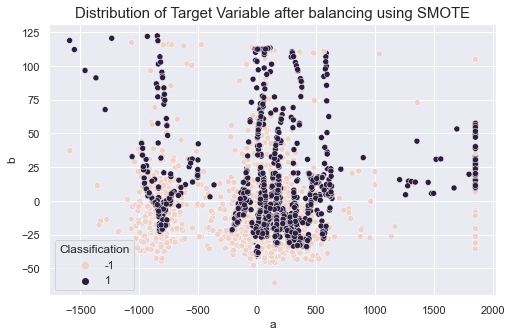

In [35]:
pca = PCA(n_components=2)
pca.fit(X_resampled)
g = pca.transform(X_resampled)
g = pd.DataFrame(g, columns=['a','b'])
g['Classification'] = y_resampled
sns.scatterplot(data = g , x='a' , y='b', hue= g['Classification'], legend= True )
#print(pca.explained_variance_)
#print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))
plt.title('Distribution of Target Variable after balancing using SMOTE', fontsize = 15)

In [36]:
# Imbalance treatment
X_resampled1, y_resampled1 = Sampling(X_train_boruta, y_train,'ADASYN')

Counter({'Classification': 1})


[277524.06750008   1012.87702214]

 Total Variance Explained: 99.93


Text(0.5, 1.0, 'Distribution of Target Variable after balancing using ADASYN')

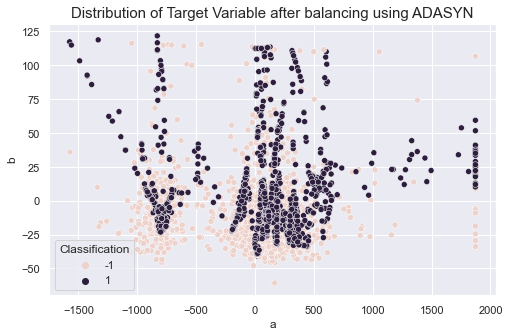

In [37]:
pca = PCA(n_components=2)
pca.fit(X_resampled1)
g = pca.transform(X_resampled1)
g = pd.DataFrame(g, columns=['a','b'])
g['Classification'] = y_resampled1
sns.scatterplot(data = g , x='a' , y='b', hue= g['Classification'], legend= True )
print(pca.explained_variance_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))
plt.title('Distribution of Target Variable after balancing using ADASYN', fontsize = 15)

In [38]:
# Imbalance treatment
X_resampled2, y_resampled2 = Sampling(X_train_boruta, y_train,'ROSE')

Counter({'Classification': 1})


[379013.49188629   1712.56349639]

 Total Variance Explained: 99.91


Text(0.5, 1.0, 'Distribution of Target Variable after balancing using ROSE')

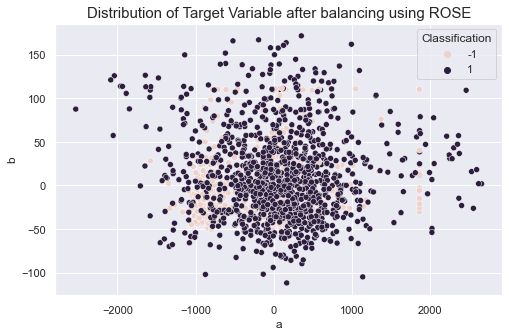

In [39]:
pca = PCA(n_components=2)
pca.fit(X_resampled2)
g = pca.transform(X_resampled2)
g = pd.DataFrame(g, columns=['a','b'])
g['Classification'] = y_resampled2
sns.scatterplot(data = g , x='a' , y='b', hue= g['Classification'], legend= True )
print(pca.explained_variance_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))
plt.title('Distribution of Target Variable after balancing using ROSE', fontsize = 15)

In [40]:
# Imbalance treatment
from imblearn.under_sampling import RandomUnderSampler
X_resampled4, y_resampled4 = Sampling(X_train_boruta, y_train,'randomunder')

Counter({'Classification': 1})


[343512.81560596   1243.85392336]

 Total Variance Explained: 99.93


Text(0.5, 1.0, 'Distribution of Target Variable after balancing using Random Undersampling')

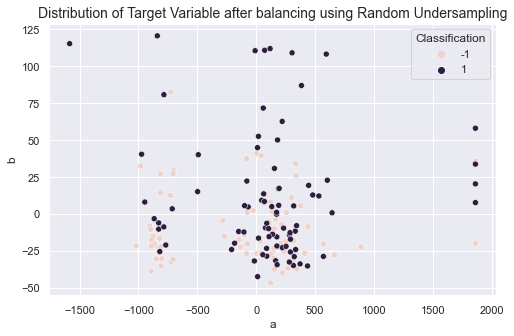

In [41]:
pca = PCA(n_components=2)
pca.fit(X_resampled4)
g = pca.transform(X_resampled4)
g = pd.DataFrame(g, columns=['a','b'])
g['Classification'] = y_resampled4
sns.scatterplot(data = g , x='a' , y='b', hue= g['Classification'], legend= True )
print(pca.explained_variance_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))
plt.title('Distribution of Target Variable after balancing using Random Undersampling', fontsize = 14)

In [42]:
y_test

,Classification
246,-1
1315,-1
444,-1
296,-1
1295,-1
...,...
174,-1
1309,-1
1333,-1
972,-1


In [43]:
# # Imbalance treatment
# X_smote, y_smote = Sampling(X_train_boruta, y_sns,'SMOTE')
# import seaborn as sns
# sns.set(rc={'figure.figsize':(8,5)})
# sns.set_theme(style="darkgrid")
# ax = sns.countplot(x="Classification", data=y_smote)
# ax.set(xlabel='Target Variable', ylabel='Count of Target Variable')
# ax.set_title("Distribution of Target Variable after balancing using SMOTE")

In [44]:
# # Imbalance treatment
# X_adasyn, y_adasyn = Sampling(X_train_boruta, y_sns,'ADASYN')
# import seaborn as sns
# sns.set(rc={'figure.figsize':(8,5)})
# sns.set_theme(style="darkgrid")
# ax = sns.countplot(x="Classification", data=y_adasyn)
# ax.set(xlabel='Target Variable', ylabel='Count of Target Variable')
# ax.set_title("Distribution of Target Variable after balancing using ADASYN")

In [45]:
# Imbalance treatment
X_rose, y_rose = Sampling(X_train_boruta, y_train,'ROSE')

Counter({'Classification': 1})


In [46]:
# import seaborn as sns
# sns.set(rc={'figure.figsize':(8,5)})
# sns.set_theme(style="darkgrid")
# ax = sns.countplot(x="Classification", data=y_rose)
# ax.set(xlabel='Target Variable', ylabel='Count of Target Variable')
# ax.set_title("Distribution of Target Variable after balancing using ROSE")

In [474]:
# y_sns = y_train
# y_sns = y_sns.replace(to_replace=[-1, 1], value=["Pass", "Fail"])
# import seaborn as sns
# sns.set(rc={'figure.figsize':(8,5)})
# sns.set_theme(style="darkgrid")
# ax = sns.countplot(x="Classification", data=y_sns)
# ax.set(xlabel='Target Variable', ylabel='Count of Target Variable')
# ax.set_title("Distribution of Target Variable before balancing")

# Scaling the data and fitting the Model
# - Random Forest Classifier

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
F1 Score: 0.8662420382165607
Sensitivity: 0.9630996309963099
Recall: 0.5238095238095238
Precision: 0.2558139534883721


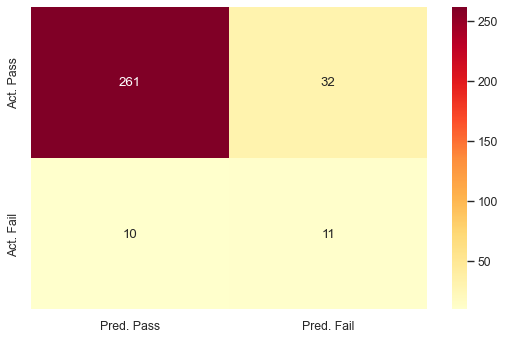

In [480]:
evaluate1(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_rose,X_test_boruta,y_rose,y_test)

# Tuning the Model

In [48]:
# Random forest 

# Defining the parameters we want to try
params = {'criterion' : ["gini","entropy","log_loss"],
          'max_depth':[4,5,6,7,8,9,10],
         'max_features':["sqrt","log2","auto",None]}
          
# We want the find the best parameters on the basis of the highest AUC
# Fitting the model as per fixed and trial paramters and applying crossvalidation using StratifiedKFold = 10
grid_searcher = GridSearchCV(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1), params,scoring='roc_auc', cv = 10, verbose=1)

# Fitting the best parameters
grid_searcher.fit(X_rose, y_rose)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt', 'log2', 'auto', None]},
             scoring='roc_auc', verbose=1)

In [49]:
# Printing the best Parameters and best estimator

#Printing the best estimator

print('\n Best estimator:')
print(grid_searcher.best_estimator_)

print('\n Best hyperparameters:')
print(grid_searcher.best_params_)


 Best estimator:
RandomForestClassifier(criterion='entropy', max_depth=10, n_jobs=-1,
                       random_state=42)

 Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt'}


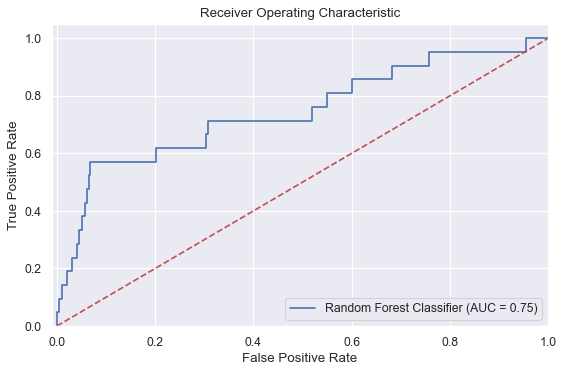

In [52]:
# Fitting the model with the tuned parameters
evaluate1(grid_searcher.best_estimator_,X_rose,X_test_boruta,y_rose,y_test)


# Checking if our model is overfitting

In [ ]:
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
test_scores=[]
train_scores=[]
for i in values:
    # configure the model
    model = RandomForestClassifier(n_estimators=100,max_features='sqrt',random_state=42,n_jobs=-1,max_depth=i,criterion='entropy')
    # fit model on the training dataset
    model.fit(X_rose, y_rose)
    # evaluate on the train dataset
    train_yhat = model.predict(X_rose)
    train_acc = accuracy_score(y_rose, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_test_boruta)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('%d train: %.3f, test: %.3f' % (i, train_acc, test_acc))

In [ ]:
# Plotting the results to have a better view
figure(figsize=(8, 5), dpi=80)
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title('Model Fit Analysis')
plt.xlabel('Max Depth (Random Forest)')
plt.ylabel('Accuracy Score')
plt.legend()
loc = list(range(21))
plt.xticks(loc)
plt.show()

In [ ]:
# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=10)
scores = cross_val_score(grid_searcher.best_estimator_, X_rose, y_rose, cv=cv, scoring = 'roc_auc')
print(scores)
print("Mean of Scores :",scores.mean())

# Final Model after considering best fit

In [ ]:
evaluate(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1,max_depth=8,criterion='entropy',max_features='sqrt'),
         X_rose,X_test_boruta,y_rose,y_test)



In [51]:
def evaluate1(model, X_train,X_test,y_train,y_test):
    """
    Function to fit any model on the train data and evaluate the model on the test data on the basis of confusion matric, 
    AUC, F1 Score, Sensitivity, Recall and Precision
    
    Required arguments - 
    model - Name of the model including model parameters
    X_train - training data
    X_test - test data
    y_train - training data target variable
    y_test - validatation data
    
    Optional arguments - None
    
    Expected output - Output message - model name and parameters,Testing Accuracy, F1 score, Sensitivity, Recall, Precision
                      Plot of the Confusion matrix and AUC
    
    """
    figure(figsize=(8, 5), dpi=80)
    model.fit(X_train, y_train)
    # Scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    y_pred = model.predict(X_test)
#     cm=confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt="d",cmap="YlOrRd",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])
#     ax = plt.gca()
# #     plot = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
#     print("Model Name:", model)
#     f1score = f1_score(y_test, y_pred, average='micro')
#     sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
#     recall = recall_score(y_test,y_pred)
#     precision = precision_score(y_test,y_pred)
#     print("F1 Score:", f1score) 
#     print("Sensitivity:" , sensitivity)
#     print("Recall:" , recall)
#     print("Precision:" , precision)
    #   #create ROC curve
    from sklearn import metrics

    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label='Random Forest Classifier (AUC = %0.2f)' % auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [ ]:
evaluate1(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1,max_depth=8,criterion='entropy',max_features='sqrt'),
         X_rose,X_test_boruta,y_rose,y_test)

In [ ]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# define dataset
# summarize class distribution
counter = Counter(y_train)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_train == label)[1]
	pyplot.scatter(y_test[row_ix, 0], y_test[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [ ]:
y